In [165]:
from cheetah import Segment, ParticleBeam
import torch
import torch.nn as nn
import torch.nn.functional as F
import epics
import os
import numpy as np
import pprint
import h5py
from typing import List, Dict, Any, Callable
import yaml
beam = ParticleBeam.from_twiss(
    beta_x=torch.tensor(9.34),
    alpha_x=torch.tensor(-1.6946),
    emittance_x=torch.tensor(1e-7),
    beta_y=torch.tensor(9.34),
    alpha_y=torch.tensor(-1.6946),
    emittance_y=torch.tensor(1e-7),
    energy=torch.tensor(90e6),
    num_particles=10000,
    total_charge=torch.tensor(1e-9)
)
print(os.getcwd())
segment = Segment.from_lattice_json("../lattices/diag0.json")

#segment.plot_twiss(reconstruction_beam)


/Users/cgarnier/Desktop/sim/Linac-Simulation-Server/notebooks


None
None


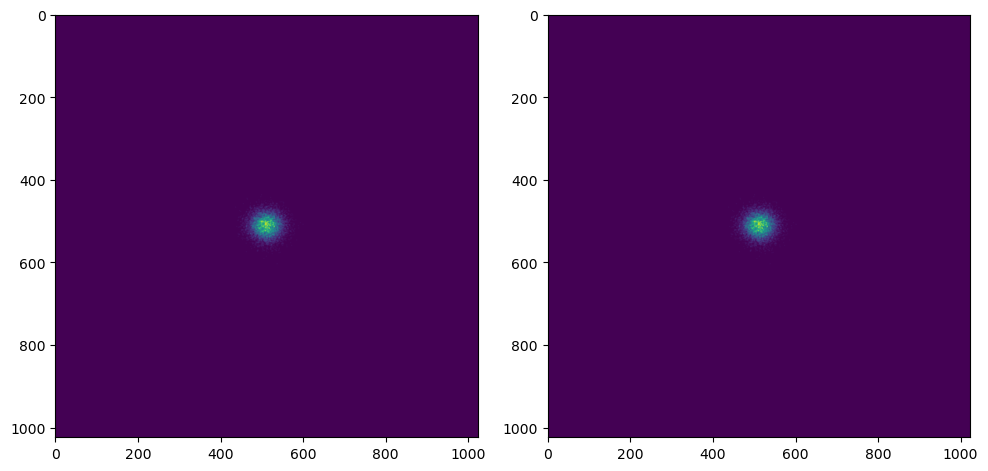

In [166]:
import matplotlib.pyplot as plt
#print(segment.otrdg02.is_active)
incoming_beam = segment.track(beam)
init_beam = segment.otrdg02.reading
segment.tcxdg0.phase= torch.tensor(90)
#segment.tcxdg0.voltage = torch.tensor(3.5e6)
outoging_beam = segment.track(beam)
otr2_data = segment.otrdg02.reading
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(init_beam)
axs[1].imshow(otr2_data)
plt.tight_layout()
plt.show()


In [167]:

def extract_group_contents(group, exclude_keys=None):
    """Safely extract datasets from a group, handling scalars and nested groups."""
    if exclude_keys is None:
        exclude_keys = set()
    data = {}
    for key in group:
        if key in exclude_keys:
            continue
        item = group[key]
        if isinstance(item, h5py.Dataset):
            data[key] = item[()] if item.shape == () else item[:]
        elif isinstance(item, h5py.Group):
            data[key] = extract_group_contents(item, exclude_keys)
    return data


aimages = {}
with h5py.File('../h5/tcav_calibration.h5', 'r') as f:
    image_root = f['images']
    exclude_keys = {'raw_images','processed_images','total_intensities', 'signal_to_noise_ratios'}

    for image_key in image_root:
        image_group = image_root[image_key]
        image_data = extract_group_contents(image_group, exclude_keys=exclude_keys)
        aimages[image_key] = image_data

In [168]:

pprint.pprint(aimages)

{'0': {'KLYS:DIAG0:11:SCALED_BCURR_PK': np.float64(57.744140625),
       'KLYS:DIAG0:11:SCALED_BVOLT_PK': np.float64(91.18175781250001),
       'KLYS:DIAG0:11:SolenoidPS1Current': np.float64(34.999000549316406),
       'KLYS:DIAG0:11:SolenoidPS1Voltage': np.float64(94.84004211425781),
       'KLYS:DIAG0:11:State': np.int64(14),
       'QDG001': np.float64(5.598746266081219),
       'QDG002': np.float64(-4.377359925679571),
       'QDG003': np.float64(5.548574743751058),
       'QDG004': np.float64(2.7207640317632893),
       'QDG005': np.float64(-3.7369521718255183),
       'QDG006': np.float64(2.1177775276502957),
       'QDG007': np.float64(-1.2044464691522203),
       'QDG008': np.float64(3.509060092489966),
       'QDG009': np.float64(-6.811715761100026),
       'QDG010': np.float64(3.45573884980197),
       'QDG011': np.float64(-3.3135387040646744),
       'TCAV:DIAG0:11:AFBENB': np.int64(1),
       'TCAV:DIAG0:11:AFBST': np.int64(3),
       'TCAV:DIAG0:11:AMPL_W0CH0': np.float64(

In [169]:
keys = [key for key in aimages.keys()]

print(aimages['0']['centroids'].shape)

centroid_stack = np.concatenate([
    aimages[key]['centroids'] for key in aimages
],axis=0)

phase_stack = np.stack([
    aimages[key]['TCAV:DIAG0:11:PREQ'] for key in aimages
])


(10, 2)


In [170]:
print(centroid_stack)
print(centroid_stack.shape)
print(phase_stack)
print(phase_stack.shape)
phase_full = np.repeat(phase_stack,10)
print(phase_full)
print(phase_full.shape)

[[828.88220601 916.92021545]
 [829.77134476 913.61846621]
 [828.66854181 920.34758356]
 [828.66854181 920.34758356]
 [827.95892085 917.24120136]
 [827.81454877 913.85650882]
 [828.28121948 916.01485484]
 [828.28121948 916.01485484]
 [823.9287644  918.39679302]
 [828.63775989 916.24967875]
 [817.95760296 912.12225612]
 [817.95760296 912.12225612]
 [819.29839591 918.7924973 ]
 [822.82252972 920.29460589]
 [819.32750219 917.75266397]
 [819.32750219 917.75266397]
 [817.22653203 916.34246434]
 [816.74862811 913.08591919]
 [816.74862811 913.08591919]
 [816.02020269 911.72473215]
 [809.36553724 913.75487913]
 [809.17413137 915.30281811]
 [809.17413137 915.30281811]
 [805.48482097 916.51079186]
 [807.63042222 910.88276102]
 [805.0769699  915.96161754]
 [805.0769699  915.96161754]
 [805.71795233 918.58535246]
 [809.49799722 920.2887432 ]
 [809.49799722 920.2887432 ]
 [793.63255604 915.11177435]
 [795.81346464 908.62506305]
 [793.05884328 916.57303513]
 [793.05884328 916.57303513]
 [794.81186704

In [171]:
from scipy.optimize import curve_fit
X= phase_full
centroids_cleaned = np.where(np.isnan(centroid_stack), 740.0, centroid_stack)
Y= centroids_cleaned
# 1. Linear fit for centroid X
def linear(x, m, b):
    return m * x + b

params_x, _ = curve_fit(linear, X, Y[:, 0])
fit_x = linear(X, *params_x)

# 2. Sine fit for centroid Y (still using degrees)
def sine_deg(x_deg, amplitude, phase_shift, frequency, offset):
    x_rad = np.radians(x_deg)
    return amplitude * np.sin(frequency * x_rad + phase_shift) + offset

p0_y = [np.ptp(Y[:, 1]) / 2, 0.0, 1.0, np.mean(Y[:, 1])]
params_y, _ = curve_fit(sine_deg, X, Y[:, 1], p0=p0_y)
fit_y = sine_deg(X, *params_y)

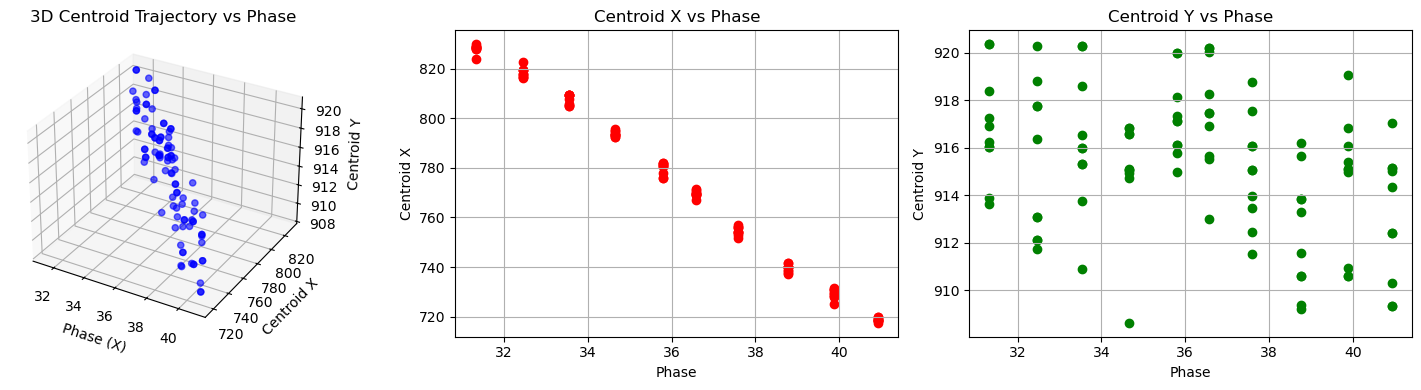

In [172]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Assume:
# X: shape (100,) — phase values
# Y: shape (100, 2) — centroid positions (x, y)

fig = plt.figure(figsize=(15, 4))

# 1. 3D Scatter plot: Centroid X vs Centroid Y vs Phase
ax1 = fig.add_subplot(131, projection='3d')
ax1.scatter(X, Y[:, 0], Y[:, 1], c='blue', alpha=0.6)
ax1.set_xlabel('Phase (X)')
ax1.set_ylabel('Centroid X')
ax1.set_zlabel('Centroid Y')
ax1.set_title('3D Centroid Trajectory vs Phase')

# 2. 2D Scatter: Centroid X vs Phase
ax2 = fig.add_subplot(132)
ax2.scatter(X, Y[:, 0], c='red', label='Centroid X')
ax2.set_xlabel('Phase')
ax2.set_ylabel('Centroid X')
ax2.set_title('Centroid X vs Phase')
ax2.grid(True)

# 3. 2D Scatter: Centroid Y vs Phase
ax3 = fig.add_subplot(133)
ax3.scatter(X, Y[:, 1], c='green', label='Centroid Y')
ax3.set_xlabel('Phase')
ax3.set_ylabel('Centroid Y')
ax3.set_title('Centroid Y vs Phase')
ax3.grid(True)

plt.tight_layout()
plt.show()


In [173]:
corr = np.corrcoef(X, Y[:, 1])[0, 1]

In [174]:
print(corr)
mean_y = np.mean(Y[:, 1])
std_y = np.std(Y[:, 1])
print(f"Centroid Y mean: {mean_y:.3f}, std dev: {std_y:.3f}")


-0.3577794736391053
Centroid Y mean: 915.315, std dev: 2.913


In [175]:
Y= centroid_stack
print(Y[:,0])

[828.88220601 829.77134476 828.66854181 828.66854181 827.95892085
 827.81454877 828.28121948 828.28121948 823.9287644  828.63775989
 817.95760296 817.95760296 819.29839591 822.82252972 819.32750219
 819.32750219 817.22653203 816.74862811 816.74862811 816.02020269
 809.36553724 809.17413137 809.17413137 805.48482097 807.63042222
 805.0769699  805.0769699  805.71795233 809.49799722 809.49799722
 793.63255604 795.81346464 793.05884328 793.05884328 794.81186704
 794.81186704 793.40290073 793.68778664 792.34071906 792.34071906
 781.9829004  782.01417109 781.34844911 781.34844911 775.71819943
 775.71819943 777.90429206 780.80418774 780.75364259 780.75364259
 771.54223354 770.39282189 770.93327796 769.35975674 769.35975674
 769.76622324 767.1474467  769.02551972 769.02551972 769.61812437
 751.60469597 754.13284442 755.78035864 754.18176475 754.18176475
 753.07854794 756.12213515 756.12213515 756.86968371 753.70174425
 737.72497288 737.2054873  740.01641225 740.01641225          nan
 738.75804

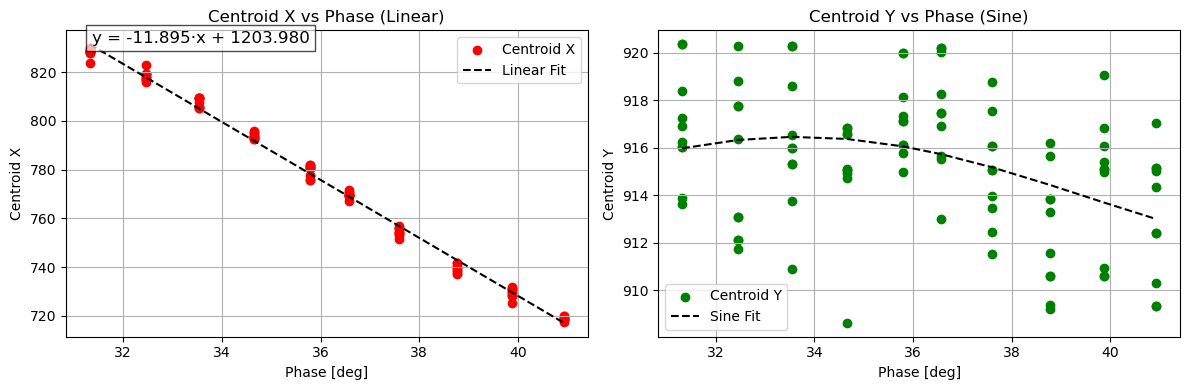

In [176]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Centroid X (Linear)
axes[0].scatter(X, Y[:, 0], color='red', label='Centroid X')
axes[0].plot(X, fit_x, color='black', linestyle='--', label='Linear Fit')
axes[0].set_title('Centroid X vs Phase (Linear)')
axes[0].set_xlabel('Phase [deg]')
axes[0].set_ylabel('Centroid X')
axes[0].legend()
axes[0].grid(True)
# Suppose params_x = [m, b]
eqn_x = f"y = {params_x[0]:.3f}·x + {params_x[1]:.3f}"
axes[0].text(0.05, 0.95, eqn_x, transform=axes[0].transAxes,
             fontsize=12, verticalalignment='bottom', bbox=dict(facecolor='white', alpha=0.7))

# Centroid Y (Sine)
axes[1].scatter(X, Y[:, 1], color='green', label='Centroid Y')
axes[1].plot(X, fit_y, color='black', linestyle='--', label='Sine Fit')
axes[1].set_title('Centroid Y vs Phase (Sine)')
axes[1].set_xlabel('Phase [deg]')
axes[1].set_ylabel('Centroid Y')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

In [177]:
print(params_x)
print(params_y)

[ -11.89504428 1203.9796897 ]
[ -2.53236931 -10.5904025   15.35100786 913.91931383]


In [178]:
def is_valid_epics_pv(pv_name: str) -> bool:
    """Check if a PV is accessible via EPICS."""
    val = epics.caget(pv_name, timeout=0.1)
    return val is not None 
segment.parameters()

<generator object Module.parameters at 0x322f66c00>

In [179]:

def get_bact_pv_from_yaml(device_name: str, yaml_data: Dict[str, Any]) -> str:
    """
    Given a lowercase device name, return the corresponding 'bact' PV from the yaml.
    Returns None if not found.
    """
    try:
        return yaml_data['magnets'][device_name.upper()]['controls_information']['PVs']['bact']
    except KeyError:
        return None


def extract_device_settings(settings: Dict[str, Any], includea_substrings: List[str], lattice_devices: List[str], yaml_data:Dict):  
    filtered_device_settings = {}
    filtered_pv_values = {}
    for setting, value in settings.items():
        if not isinstance(setting,str):
            continue
        if any(sub in setting for sub in includea_substrings):
            if setting.lower() in lattice_devices:
                pv_name = get_bact_pv_from_yaml(device_name= setting, yaml_data =yaml_data)
                filtered_device_settings[pv_name] = value
            elif is_valid_epics_pv(setting):
                 filtered_pv_values[setting]= value
    return filtered_device_settings, filtered_pv_values



In [180]:
segment_devices = [element.name for element in segment.elements]
substrings = ['QDG', 'TCAV', 'KLYS']
init_lattice_settings = aimages['0']
with open("../yaml/DIAG0.yaml", "r") as f:
    yaml_data = yaml.safe_load(f)
filtered_device_settings, filtered_pv_values = extract_device_settings(settings=init_lattice_settings,
                                                                    includea_substrings=substrings,
                                                                    lattice_devices= segment_devices,
                                                                    yaml_data = yaml_data )






cannot connect to TCAV:DIAG0:11:AMPL_W0CH0
cannot connect to TCAV:DIAG0:11:PACT_AVGNT
cannot connect to KLYS:DIAG0:11:State
cannot connect to KLYS:DIAG0:11:SCALED_BVOLT_PK
cannot connect to KLYS:DIAG0:11:SCALED_BCURR_PK
cannot connect to KLYS:DIAG0:11:SolenoidPS1Voltage
cannot connect to KLYS:DIAG0:11:SolenoidPS1Current


In [181]:
print(segment_devices)
pprint.pprint(filtered_device_settings)
pprint.pprint(filtered_pv_values)
#TODO: so this is going to be kind of jenky, there is no way to caput to the accelerator from madname so we need a lookup table to get
# quad bctrls
#TODO: would be helpful if h5py file gave a list of pvs only.

['beam0', 'dcm4b', 'qcm01', 'dcm5', 'cm01end', 'dcmcm1', 'homcm', 'dcap0da', 'astra', 'dcap0db', 'fc1', 'dmsc0da', 'blf1', 'dmsc0db', 'vgl0bd', 'dmsc0dc', 'vpl0bd', 'dmsc0dd', 'msc0d', 'vvl0bd', 'endl0b', 'beghtr', 'd0h00a', 'rfb0h00', 'd0h00b', 'pc0h00_drift', 'pc0h00_aperture', 'd0h00c', 'q0h01', 'd0h01a', 'yc0h01', 'd0h01b', 'q0h02', 'd0h02a', 'xc0h01', 'd0h02b', 'dp0h01', 'd0h02c', 'dp0h02', 'd0h02d', 'dp0h03', 'd0h02e', 'xc0h03', 'd0h02f', 'q0h03', 'd0h03a', 'yc0h03', 'd0h03b', 'q0h04', 'd0h04a', 'rfb0h04', 'd0h04b', 'otr0h04', 'otr0h04_yag', 'd0h04c', 'ws0h04', 'd0h04d', 'bz0h04', 'd0h04e', 'q0h05', 'd0h05a', 'yc0h05', 'd0h05b', 'q0h06', 'd0h06a', 'xc0h05', 'd0h06b', 'xc0h07', 'd0h06c', 'q0h07', 'd0h07a', 'yc0h07', 'd0h07b', 'q0h08', 'd0h08a', 'rfb0h08', 'd0h08b', 'lhbegb', 'bcxh1', 'dh01a', 'bpmh1', 'dh01b', 'mirlhu', 'dh01c', 'bcxh2', 'dh02a', 'cehtr_drift', 'cehtr_aperture', 'dh02b', 'yagh1', 'dh02c', 'umhtr', 'htrundb', 'umhtr', 'dh02d', 'yagh2', 'dh02e', 'bcxh3', 'dh03a', 'm

In [182]:
epics.caput('TCAV:DIAG0:11:AFBENB', np.int64(1))

print(epics.caget('TCAV:DIAG0:11:PREQ', use_monitor=False ))

0.0


In [183]:
def set_quads(quad_dict):
    for quad, value in quad_dict.items():
        epics.caput(quad,value)

In [184]:
set_quads(filtered_device_settings)

None
None


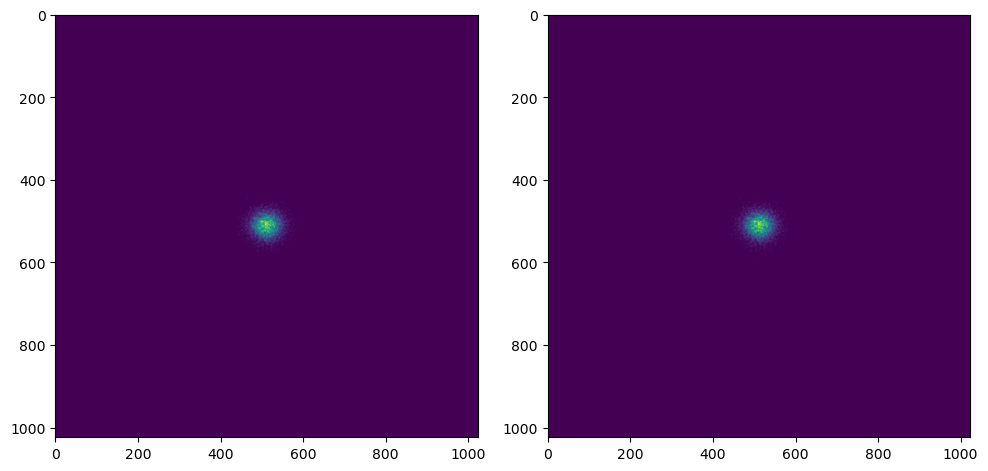

In [185]:
import matplotlib.pyplot as plt
#print(segment.otrdg02.is_active)
incoming_beam = segment.track(beam)
init_beam = segment.otrdg02.reading
segment.tcxdg0.phase= torch.tensor(90)
#segment.tcxdg0.voltage = torch.tensor(3.5e6)
outoging_beam = segment.track(beam)
otr2_data = segment.otrdg02.reading
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(init_beam)
axs[1].imshow(otr2_data)
plt.tight_layout()
plt.show()
